In [1]:
%matplotlib inline
from collections import namedtuple
ArgsTuple = namedtuple("ArgsTuple", "cpu_mode demo_net gpu_id")

In [2]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from utils.cython_nms import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16',
                  'vgg16_fast_rcnn_iter_40000.caffemodel'),
        'vgg_cnn_m_1024': ('VGG_CNN_M_1024',
                           'vgg_cnn_m_1024_fast_rcnn_iter_40000.caffemodel'),
        'caffenet': ('CaffeNet',
                     'caffenet_fast_rcnn_iter_40000.caffemodel')}

In [3]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [4]:
def demo(net, image_name, classes):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load pre-computed Selected Search object proposals
    box_file = os.path.join(cfg.ROOT_DIR, 'data', 'demo',
                            image_name + '_boxes.mat')
    obj_proposals = sio.loadmat(box_file)['boxes']

    # Load the demo image
    im_file = os.path.join(cfg.ROOT_DIR, 'data', 'demo', image_name + '.jpg')
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im, obj_proposals)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls in classes:
        cls_ind = CLASSES.index(cls)
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        keep = np.where(cls_scores >= CONF_THRESH)[0]
        cls_boxes = cls_boxes[keep, :]
        cls_scores = cls_scores[keep]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        print 'All {} detections with p({} | box) >= {:.1f}'.format(cls, cls,
                                                                    CONF_THRESH)
        vis_detections(im, cls, dets, thresh=CONF_THRESH)



Loaded network /mnt/y/ronghang/workspace/fast-rcnn/data/fast_rcnn_models/vgg16_fast_rcnn_iter_40000.caffemodel
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/000004.jpg
Detection took 0.929s for 2888 object proposals
All car detections with p(car | box) >= 0.8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/001551.jpg
Detection took 0.518s for 2057 object proposals
All sofa detections with p(sofa | box) >= 0.8
All tvmonitor detections with p(tvmonitor | box) >= 0.8


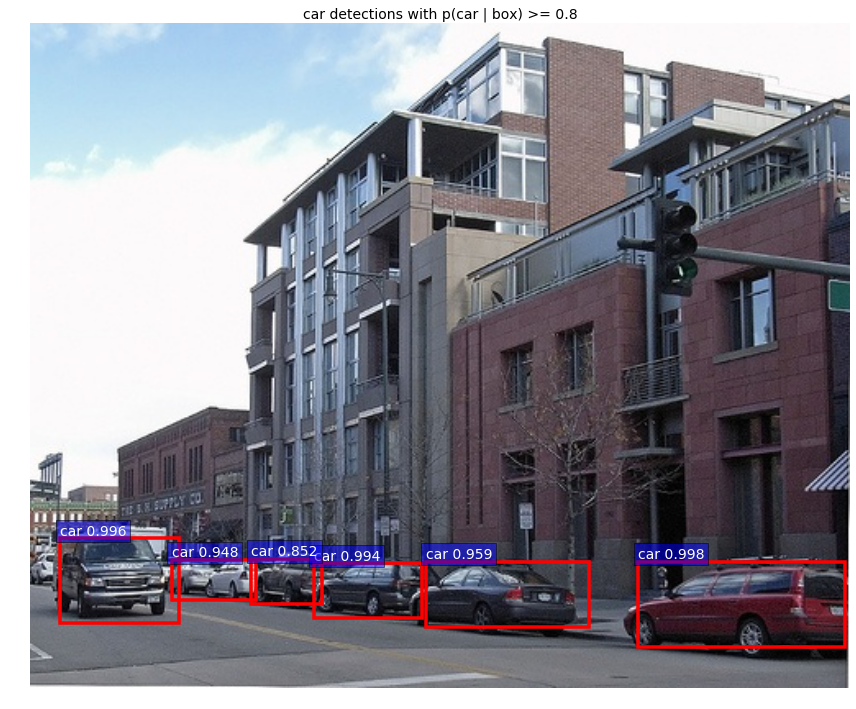

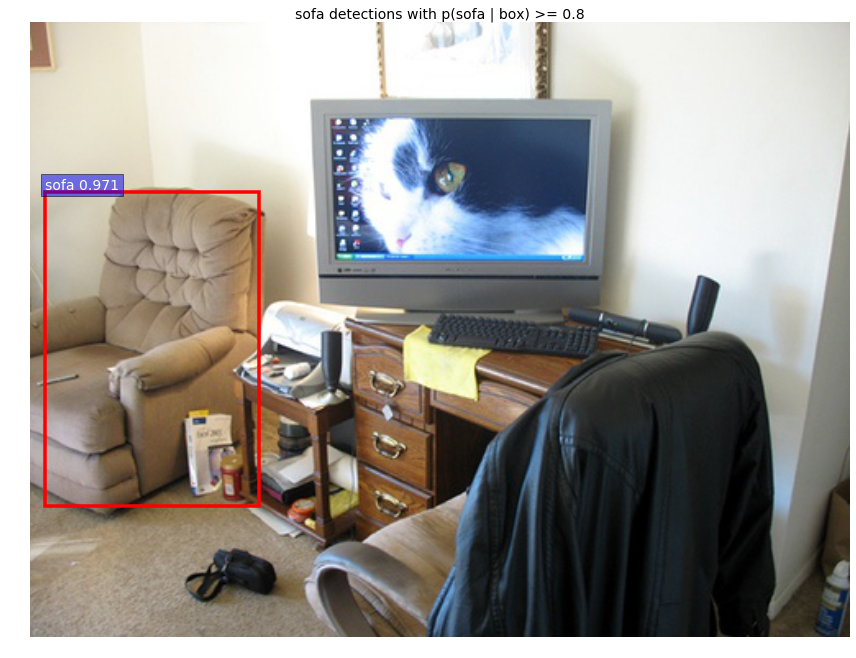

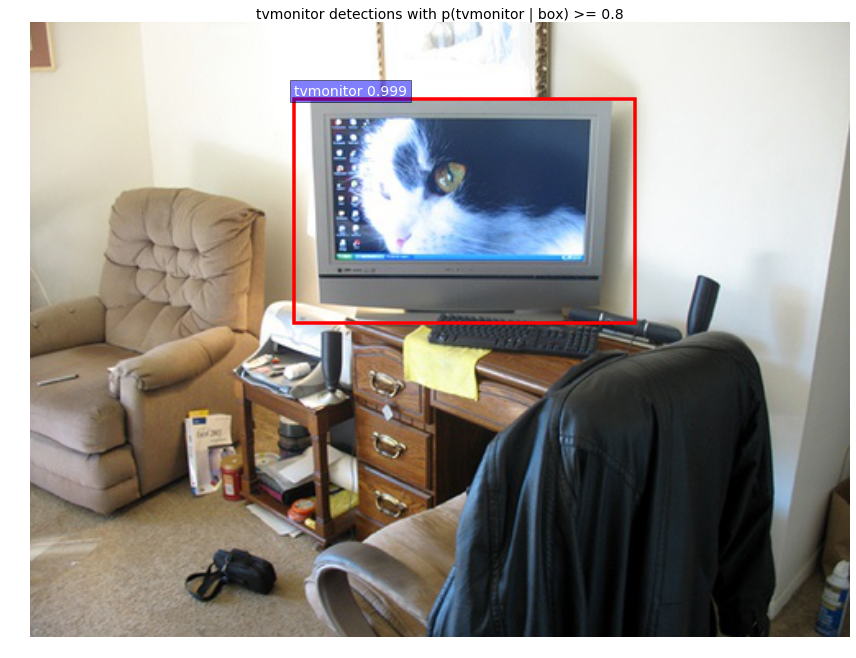

In [5]:
if __name__ == '__main__':
    
    args = ArgsTuple(False, "vgg16", 0)

    prototxt = os.path.join(cfg.ROOT_DIR, 'models', NETS[args.demo_net][0],
                            'test.prototxt')
    caffemodel = os.path.join(cfg.ROOT_DIR, 'data', 'fast_rcnn_models',
                              NETS[args.demo_net][1])

    if not os.path.isfile(caffemodel):
        raise IOError(('{:s} not found.\nDid you run ./data/scripts/'
                       'fetch_fast_rcnn_models.sh?').format(caffemodel))

    if args.cpu_mode:
        caffe.set_mode_cpu()
    else:
        caffe.set_mode_gpu()
        caffe.set_device(args.gpu_id)
    net = caffe.Net(prototxt, caffemodel, caffe.TEST)

    print '\n\nLoaded network {:s}'.format(caffemodel)

    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/000004.jpg'
    demo(net, '000004', ('car',))

    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/001551.jpg'
    demo(net, '001551', ('sofa', 'tvmonitor'))

    plt.show()
